# Imports

In [1]:
# %%bash

# git clone https://github.com/Qiwei97/Gym-PM.git
# cd Gym-PM
# pip install -e .

In [2]:
# Import Modules
import numpy as np
import gym
from gym.wrappers.normalize import NormalizeReward

import gym_pm
from gym_pm.utils import evaluate_baseline, evaluate_policy, plot_metrics
from gym_pm.envs import Assemblyv2_Env

import ray
from ray.tune.registry import register_env
from ray.rllib.agents import ppo

# Environment

In [3]:
def env_wrapper(env_config):

  wrapped_env = Assemblyv2_Env(**env_config) # Use the appropriate env
  wrapped_env = NormalizeReward(wrapped_env)

  return wrapped_env  # return an env instance

env_name = "Assembly-v2"
register_env(env_name, env_wrapper)

# Training

In [4]:
config = ppo.DEFAULT_CONFIG.copy()
# Training Params
config['seed'] = 1
config['batch_mode'] = 'complete_episodes'
config['exploration_config'] = {'type': 'SoftQ'}
config['entropy_coeff'] = 0.001
config['vf_clip_param'] = 1e5
config['kl_target'] = 0.03
# Multiprocessing
config["num_gpus"] = 0
config["num_workers"] = 16
# Preprocessing
config["observation_filter"] = 'MeanStdFilter'
config['preprocessor_pref'] = 'rllib'

trainer = ppo.PPOTrainer(config=config, env=env_name)

2022-03-25 12:38:56,957	WARNING ppo.py:231 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=16 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 250.
2022-03-25 12:39:13,518	INFO trainable.py:130 -- Trainable.setup took 16.562 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


In [5]:
results = []

for i in range(int(1000)):

  res = trainer.train()
  results.append(res)

  if (i+1) % 10 == 0:
    print('Iter: {} Reward: {:.2f}'.format(i+1, res['episode_reward_mean']))
    
trainer.save('Models/Assemblyv2/PPO')

2022-03-25 12:39:33,718	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
(RolloutWorker pid=47848) 2022-03-25 12:41:01,569	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Iter: 10 Reward: -131.80
Iter: 20 Reward: -7.46
Iter: 30 Reward: -6.31
Iter: 40 Reward: -27.11
Iter: 50 Reward: -34.67
Iter: 60 Reward: -5.77
Iter: 70 Reward: 0.22
Iter: 80 Reward: 0.40
Iter: 90 Reward: -32.12
Iter: 100 Reward: -7.04
Iter: 110 Reward: -21.57
Iter: 120 Reward: -1.06
Iter: 130 Reward: -8.19
Iter: 140 Reward: -0.11
Iter: 150 Reward: -11.47
Iter: 160 Reward: -1.59
Iter: 170 Reward: -2.78
Iter: 180 Reward: -12.53
Iter: 190 Reward: -5.80
Iter: 200 Reward: -20.90
Iter: 210 Reward: -2.95
Iter: 220 Reward: -3.82
Iter: 230 Reward: -7.06
Iter: 240 Reward: -0.77
Iter: 250 Reward: -39.19
Iter: 260 Reward: -4.06
Iter: 270 Reward: -5.27
Iter: 280 Reward: -54.13
Iter: 290 Reward: -64.13
Iter: 300 Reward: -48.17
Iter: 310 Reward: -42.50
Iter: 320 Reward: -13.59
Iter: 330 Reward: -58.02
Iter: 340 Reward: -1.74
Iter: 350 Reward: -1.31
Iter: 360 Reward: -0.83
Iter: 370 Reward: -2.38
Iter: 380 Reward: -0.27
Iter: 390 Reward: -0.03
Iter: 400 Reward: 0.12
Iter: 410 Reward: 0.22
Iter: 420 Rew

2022-03-26 19:26:23,461	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Iter: 1000 Reward: 0.50


'Models/Assemblyv2/PPO/checkpoint_001000/checkpoint-1000'

# Evaluation

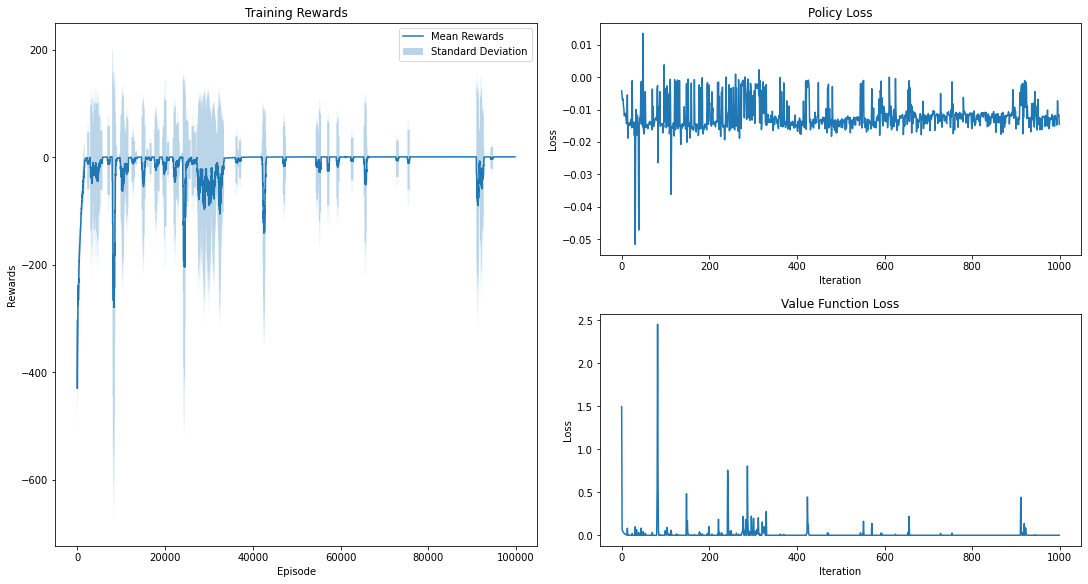

In [6]:
plot_metrics(results)

In [7]:
# trainer = ppo.PPOTrainer(config=config, env=env_name)
# trainer.restore('Models/Assemblyv2/PPO/checkpoint_001000/checkpoint-1000')

In [8]:
eval_env = Assemblyv2_Env(config)

baseline = evaluate_baseline(eval_env,
                             repair_policy=1, 
                             repair_interval=10,
                             resupply_threshold=28,
                             output_threshold=15)

result = evaluate_policy(eval_env, trainer)

print('Baseline: {}'.format(baseline.reward.mean()))
print('Agent Performance: {}'.format(result.reward.mean()))

2022-03-26 19:27:42,446	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


Baseline: 264.9511143062545
Agent Performance: 227.57287922358014


In [9]:
result.to_csv('Output/Assemblyv2_PPO.csv')

In [10]:
agent, base0, base10 = [], [], []

for _ in range(5):
    agent.append(evaluate_policy(eval_env, trainer).reward.mean())
    base0.append(evaluate_baseline(eval_env,
                                   repair_policy=0,
                                   resupply_threshold=28,
                                   output_threshold=15).reward.mean())
    base10.append(evaluate_baseline(eval_env,
                                    repair_policy=1, 
                                    repair_interval=10,
                                    resupply_threshold=28,
                                    output_threshold=15).reward.mean())

print(np.mean(agent))
print(np.mean(base0))
print(np.mean(base10))

224.27692307692308
255.1568655643422
264.5508267433501
